# LLM fine-tuning with Kili: Training a specialized summarizer with OpenAI fine-tuning

1. From the PubMed summarization dataset https://huggingface.co/datasets/ccdv/pubmed-summarization , take a subset (~20 examples) of the training set with input texts that are not too long (to fit the max token number of GPT-3.5 = <4096), and do the same on the validation dataset.
2. Run GPT-3.5 with a summarization prompt on the validation subset and on the training subset, and compute a simple confidence score that compares several generations with the ROUGE scores.
3. Identify the 10 worst examples w.r.t. the confidence score on the training subset.
4. in Kili, fix the 10 worst examples using the ground truth annotations from the dataset (to simulate human correction).
5. Fine tuning of GPT3.5 on the 10 fixed examples using the input text and the ground truth summaries of the training subset.
6. Run the fine-tuned model on the validation dataset, and compute the global summarization score again, it should perform better (hopefully)!

# Setup

In [ ]:
! pip install -q datasets tiktoken openai rouge-score pandas tqdm kili ipywidgets matplotlib tenacity jinja2

It is also required that you have an Open AI account with API credits. You should set your Open AI api key in the `OPENAI_API_KEY` environment variable.

## Build the dataset
Download the PubMed summarization dataset and take a subset (~20 examples) of the training set with input texts that are not too long (< 3500 tokens). More realistic pipelines should take more examples, more than 100 for instance.

In [ ]:
import tiktoken
from datasets import load_dataset

INITIAL_DATASET_SIZE = 1000
FINAL_DATASET_SIZE = 20
MAX_INPUT_TOKENS = 3500
MIN_INPUT_TOKENS = 1000

tokenizer = tiktoken.get_encoding("cl100k_base")


def process_dataset(dataset):
    """Keep the examples that are between MIN_INPUT_TOKENS and MAX_INPUT_TOKENS and select the first FINAL_DATASET_SIZE examples."""

    def tokenize(examples):
        return tokenizer.encode(examples["article"])

    return (
        dataset.select(range(INITIAL_DATASET_SIZE))
        .filter(lambda example: MAX_INPUT_TOKENS > len(tokenize(example)) > MIN_INPUT_TOKENS)
        .select(range(FINAL_DATASET_SIZE))
    )


dataset = load_dataset("ccdv/pubmed-summarization")
dataset_train = process_dataset(dataset["train"])
dataset_validation = process_dataset(dataset["validation"])

In [ ]:
print(dataset_train[18]["article"])

the centers for disease control and prevention ( cdc ) and united states preventive services task force ( uspstf ) recommend universal hiv screening for all pregnant women entering prenatal care [ 1 , 2 ] . 
 this screening enables hiv - infected women and their infants to benefit from appropriate and timely interventions such as antiretroviral medications . 
 when the recommended antiretroviral and obstetric interventions are used , a woman who knows of her hiv infection early in pregnancy now has a less than 2% chance of delivering an hiv - infected infant . without intervention , this risk is approximately 25% in the united states [ 36 ] . 
 testing for hiv began in 1985 with the introduction of the enzyme immunoassay ( eia ) . in order to account for false positive results using screening tests in a low - prevalence population 
 , confirmatory testing has been implemented using a western blot or immunofluorescence assay .   in a low - prevalence population , 
 the false positive ra

In [ ]:
assert len(dataset_train) == FINAL_DATASET_SIZE
assert len(dataset_validation) == FINAL_DATASET_SIZE

## Run GPT3.5 to create the summaries

Now, we use GPT 3.5 turbo to compute summaries of the input articles. We generate multiple summaries using high temperature to get randomness (1.0), and we use the rouge score between the first generation and the following ones to see how much the summary varies. This is a simple metric that can indicate which input articles are more difficult to summarize for the LLM. Note that there are more reliable metrics based on log probabilities or self-check, that we did not implement here for the sake of simplicity.

In [ ]:
import os

import openai
from rouge_score import rouge_scorer
from tenacity import retry, stop_after_attempt, wait_random_exponential
from tqdm.auto import tqdm

openai.api_key = os.environ["OPENAI_API_KEY"]

scorer = rouge_scorer.RougeScorer(["rouge1", "rougeL"], use_stemmer=True)

SYSTEM_PROMPT = (
    "This system is skilled in summarizing articles. The summaries should use the same narrative"
    " voice as the original, and avoid meta-statements such as 'this article is about'."
)
USER_PROMPT_TEMPLATE = "Summarize the following article in less than 250 words: {}"
N_SHOTS = 5


def summarize(article, compute_confidence_score):
    @retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
    def inner_summarize(article, temperature):
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": USER_PROMPT_TEMPLATE.format(article)},
            ],
            temperature=temperature,
            max_tokens=500,
        )
        return response.choices[0].message.content

    base_answer = inner_summarize(article, temperature=0)

    if not compute_confidence_score:
        summary = {
            "initial_summary": base_answer,
        }
    else:
        rouge_scores = []
        for shot in tqdm(range(N_SHOTS), desc="Other shots to compute confidence score"):
            shot_answer = inner_summarize(article, temperature=1.0)
            rouge_scorer = scorer.score(base_answer, shot_answer)
            rouge_scores.append(
                (rouge_scorer["rouge1"].fmeasure + rouge_scorer["rougeL"].fmeasure) / 2
            )

        avg_rouge_score = sum(rouge_scores) / len(rouge_scores)

        summary = {
            "initial_summary": base_answer,
            "initial_confidence_score": avg_rouge_score,
        }

    return summary

In [ ]:
print(summarize(dataset_train[9]["article"]))

Other shots to compute confidence score:   0%|          | 0/5 [00:00<?, ?it/s]

{'initial_summary': 'The article discusses the risks associated with lumbar transforaminal injections and whether they should be discontinued. It presents a case of a 47-year-old man who developed paraplegia after undergoing an epidural steroid injection (ESI) for recurrent pain. The initial MRI was unremarkable, but a later evaluation showed conus medullaris syndrome and a conus infarct. The article also mentions a search of the PubMed database for similar cases and discusses the potential benefits and risks of ESI. It emphasizes that while this severe complication is rare, its true incidence is unknown. The article suggests that the rarity of this complication should not lead to the discontinuation of transforaminal ESI, but rather it should be discussed with patients during the consent process. The article also discusses the potential causes of spinal cord infarction during ESI, including direct arterial injection and embolic incidents. It mentions the importance of adhering to stan

We see above that we can obtain a summary from GPT 3.5 turbo and an assosiated confidence score. It is now time to compute the summaries and the confidence score for the training dataset. This will take around 30 minutes to run on a training dataset of 20 examples, most of the time being spent on the generations used to compute the confidence score.

In [ ]:
import pandas as pd
from tqdm.auto import tqdm


def compute_and_save_initial_summary(dataset, filename, compute_confidence_score):
    if os.path.exists(filename):
        print("Loading from file {}".format(filename))
    else:
        data = []
        for example in tqdm(dataset, desc="Summarizing"):
            data.append(
                {
                    "article": example["article"],
                    "abstract": example["abstract"],
                    **summarize(example["article"], compute_confidence_score),
                }
            )
        pd.DataFrame.from_records(data).to_json(filename)
    return pd.read_json(filename)


ds_train_initial_summary = compute_and_save_initial_summary(
    dataset_train, "initial_summary_train.json", compute_confidence_score=True
)

ds_validation_initial_summary = compute_and_save_initial_summary(
    dataset_validation, "initial_summary_validation.json", compute_confidence_score=False
)

## Global summarization score

We compute a summarization score on the validation dataset using the input articles and manual references. We use a combined rouge score between the generated summaries and the manual references. It is run before fine-tuning to be sure that the fine-tuning will actually improve the score. 

In [ ]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(["rouge1", "rougeL"], use_stemmer=True)


def add_rouge_score(dataset: pd.DataFrame, summary_version: str):
    if f"{summary_version}_rougeCombined" not in dataset.columns:

        def compute_rouge(example):
            scores = scorer.score(example[f"{summary_version}_summary"], example["abstract"])
            example[f"{summary_version}_rouge1"] = scores["rouge1"].fmeasure
            example[f"{summary_version}_rougeL"] = scores["rougeL"].fmeasure
            example[f"{summary_version}_rougeCombined"] = (
                scores["rougeL"].fmeasure + scores["rouge1"].fmeasure
            ) / 2
            return example

        dataset = dataset.apply(compute_rouge, axis=1)
    return dataset


ds_validation_initial_summary = add_rouge_score(ds_validation_initial_summary, "initial")

In [ ]:
ds_validation_initial_summary

,article,abstract,initial_summary,initial_confidence_score,initial_rouge1,initial_rougeL,initial_rougeAgg,initial_rougeCombined
0,results of a liquid culturing system ( bd bact...,to determine differences in the ability of myc...,The article discusses the results of a study t...,0.622230,0.238710,0.141935,0.190323,0.190323
1,anemia is a global health problem and an ind...,epidemiological evidence suggests that circula...,Anemia is a global health problem and is a ris...,0.694236,0.503018,0.289738,0.396378,0.396378
2,takayasu 's arteritis ( ta ) is a chronic infl...,takayasu 's arteritis is a chronic inflammator...,Takayasu's arteritis (TA) is a chronic inflamm...,0.576887,0.262172,0.209738,0.235955,0.235955
3,quality in healthcare has gained new definitio...,background : quality gap is the gap between cl...,The article discusses the importance of qualit...,0.515958,0.316302,0.165450,0.240876,0.240876
4,in our recent article sequestosome 1/p62 faci...,we recently reported that depletion of p62 in ...,The article discusses the role of the adaptor ...,0.630270,0.271698,0.196226,0.233962,0.233962
5,female patients aged 20 - 55 years consulted t...,objective : the aim of this study is to examin...,This article discusses a study that aimed to e...,0.563877,0.491150,0.252212,0.371681,0.371681
6,"in the previous issue of critical care , reint...",gastrointestinal dysfunction is an intuitively...,"In a recent study published in Critical Care, ...",0.605118,0.374233,0.184049,0.279141,0.279141
7,application of science and technology for the ...,background : police personnel play an importan...,"Forensic odontology, the branch of dentistry t...",0.584087,0.485714,0.220408,0.353061,0.353061
8,it adopts a right - handed helically coiled co...,supercoiling is a fundamental property of dna ...,The article discusses the role of supercoiling...,0.587060,0.377465,0.191549,0.284507,0.284507
9,henoch schonlein purpura ( hsp ) is an immune...,we describe a 26-year - old woman who presente...,Henoch Schonlein purpura (HSP) is a type of va...,0.556760,0.324723,0.206642,0.265683,0.265683


# Fix the worst examples in the training dataset with Kili

## Select the worst examples

We keep the worst examples in term of confidence score to focus the fine-tuning on the most difficult examples. We use the ground truth summaries to fix the input articles, which is a SIMULATION of human correction. In a real use case, we would use the annotations from Kili to fix the input articles.

In [ ]:
to_keep = 10
worst_examples_train = ds_train_initial_summary.sort_values(by="initial_confidence_score").head(
    to_keep
)

# Create a Kili project to fix the worst examples

In [ ]:
from kili.client import Kili

kili = Kili()

project = kili.create_project(
    title="Summarization",
    description="Summarize PubMed articles",
    input_type="TEXT",
    json_interface={
        "jobs": {
            "TRANSCRIPTION_JOB": {
                "content": {"input": "textField"},
                "instruction": "Fix the summary",
                "mlTask": "TRANSCRIPTION",
                "required": 1,
                "isChild": False,
                "isNew": False,
            }
        }
    },
)

# add the worst examples to the project
asset_results = kili.append_many_to_dataset(
    project_id=project["id"],
    content_array=[example[1]["article"] for example in worst_examples_train.iterrows()],
)

# add manual labels using the ground-truth abstract. This is cheating! you may not
# have the reference summary in real life. You should replace the "abstract" key by
# "initial_summary" to work on a more realistic setting where you do not have the
# reference summary.
kili.append_labels(
    project_id=project["id"],
    asset_id_array=asset_results["asset_ids"],
    json_response_array=[
        {"TRANSCRIPTION_JOB": {"text": example[1]["abstract"]}}
        for example in worst_examples_train.iterrows()
    ],
)

# Fine tuning of GPT3.5

Once we have fixed the problematic examples in Kili, we can retrieve them, build a dataset file, and then launch a fine-tuning process with OpenAI.

In [ ]:
# Fetching fixed examples from kili
assets = kili.assets(project_id=project["id"], fields=["id", "content", "latestLabel.jsonResponse"])

In [ ]:
import json

import requests

# Fine tuning of GPT3.5 on the fixed samples requires to create a training dataset file.

with open("finetuning_trainingdata.jsonl", "w") as fp:
    for asset in assets:
        article = requests.get(asset["content"]).text
        summary = asset["latestLabel"]["jsonResponse"]["TRANSCRIPTION_JOB"]["text"]

        train_messages = {
            "messages": [
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": USER_PROMPT_TEMPLATE.format(article)},
                {"role": "assistant", "content": f"{summary}"},
            ]
        }

        fp.write(json.dumps(train_messages) + "\n")

In [ ]:
import openai

fine_tuning_file = openai.File.create(
    file=open("finetuning_trainingdata.jsonl", "rb"),
    purpose="fine-tune",
    user_provided_filename="finetuning_trainingdata.jsonl",
)

And finally we launch the fine-tuning using the following command:

In [ ]:
fine_tuning_process = openai.FineTuningJob.create(
    training_file=fine_tuning_file["id"], model="gpt-3.5-turbo-0613"
)

# Run and evaluate on the validation dataset

## Wait until the fine tuning is complete

In [ ]:
import time

while openai.FineTuningJob.retrieve(id=fine_tuning_process.id).status != "succeeded":
    time.sleep(10)
model_id = openai.FineTuningJob.retrieve(id=fine_tuning_process.id)["fine_tuned_model"]

## Compute final summary with the fine-tuned version
We now have a fine-tuned GPT-3.5-turbo model that we can use to generate the summaries of the validation dataset. We can then compute the global summarization score again, and see if it has improved.

In [ ]:
def add_final_summary(input_df, fine_tuning_model_id):
    """Add the final summary to the dataframe"""

    def inner_add_final_summary(example):
        response = openai.ChatCompletion.create(
            model=fine_tuning_model_id,
            messages=[
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": USER_PROMPT_TEMPLATE.format(example)},
            ],
            temperature=0,
            max_tokens=500,
        )
        example["final_summary"] = response.choices[0].message.content

        return example

    return input_df.apply(inner_add_final_summary, axis=1)


ds_validation_with_final_summary = add_final_summary(ds_validation_initial_summary, model_id)

## Evaluation
Time to evaluate to see if the metric did improve

In [ ]:
ds_validation_with_final_summary = add_rouge_score(ds_validation_with_final_summary, "final")

Text(0.05, 0.4, 'Final is better')

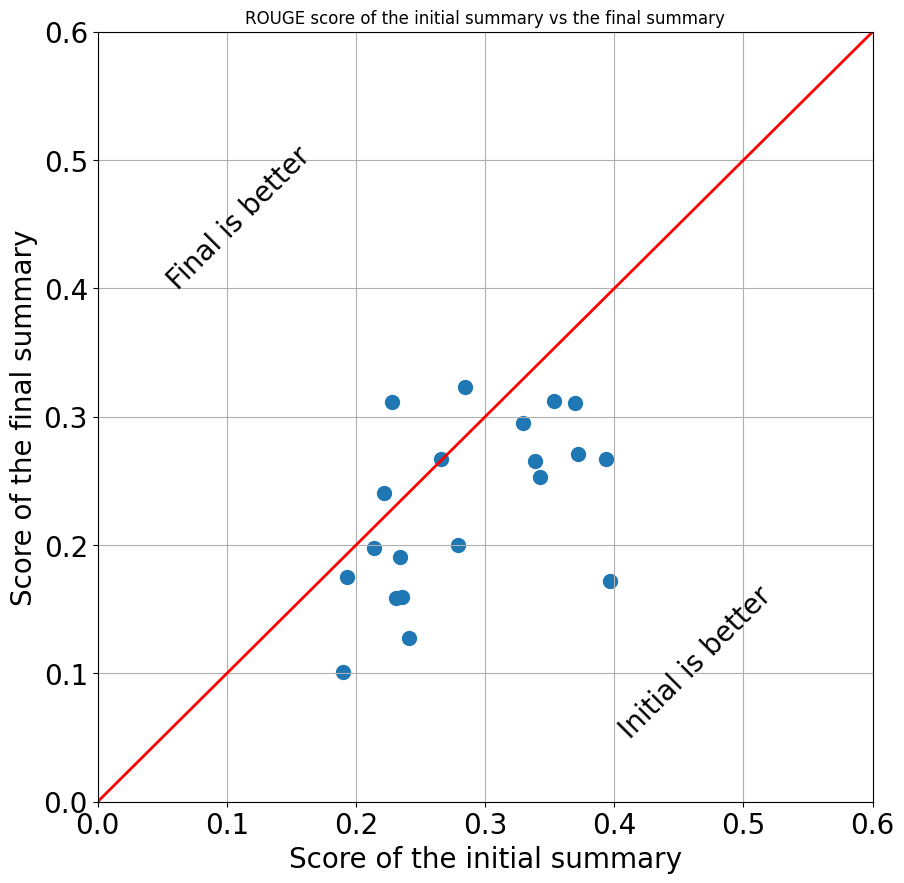

In [ ]:
from matplotlib import pyplot as plt

ds_validation_with_final_summary[["initial_rougeCombined", "final_rougeCombined"]].plot(
    kind="scatter",
    x="initial_rougeCombined",
    y="final_rougeCombined",
    title="ROUGE score of the initial summary vs the final summary",
    figsize=(10, 10),
    xlim=(0, 0.6),
    ylim=(0, 0.6),
    grid=True,
    s=100,
    fontsize=20,
)
plt.plot([0, 1], [0, 1], color="red", linewidth=2)
plt.xlabel("Score of the initial summary", fontsize=20)
plt.ylabel("Score of the final summary", fontsize=20)
plt.text(x=0.4, y=0.05, s="Initial is better", fontsize=20, rotation=45)
plt.text(x=0.05, y=0.4, s="Final is better", fontsize=20, rotation=45)

The graph above depicts for each article the ROUGE scores obtained before ("initial") and after ("final") fine-tuning. We see that in general the fine-tuned model does not perform better than the initial model.

In [ ]:
# Display the results on the worst examples.
worst_examples_validation = ds_validation_with_final_summary.sort_values(
    by="initial_rougeCombined"
).head(to_keep)
worst_examples_validation[["initial_summary", "final_summary"]].style.set_properties(
    subset=["initial_summary", "final_summary"], **{"width": "500px"}
)

,initial_summary,final_summary
0,"The article discusses the results of a study that examined the susceptibility of Beijing and EAI genotype strains of Mycobacterium tuberculosis to various drugs. The study used a liquid culturing system called the BD BACTEC MGIT 960 system to determine the susceptibility of the strains to isoniazid, rifampin, moxifloxacin, and amikacin. The results showed that all 5 Beijing and 5 EAI genotype strains were susceptible to these drugs. The study also determined the mutation frequencies of the strains by exposing them to critical drug concentrations. The mutation frequencies were similar for isoniazid, moxifloxacin, and amikacin, but significantly different for rifampin. This difference in mutation frequencies for rifampin is an important finding, as rifamycin drugs are commonly used to treat tuberculosis. The study also investigated the time-kill kinetics of rifampin on two strains with different mutation frequencies. The results showed that low concentrations of rifampin were effective in killing the bacteria, but higher concentrations were needed to achieve 100% killing, especially for the Beijing genotype strain. This finding is relevant in the clinical context, as high-density populations of mycobacteria are expected in infected tissues of tuberculosis patients. The study concludes that the currently used drug susceptibility assays do not differentiate between the susceptibility of Beijing and EAI genotype strains. It suggests that determining mutation frequencies may be more informative than drug susceptibility assays. The study also highlights the need for anti-tuberculosis drug treatments that can prevent resistance among Beijing genotype cases and suggests that genotype-specific therapy may be justified.",The article discusses the results of a study that compared the ability of various liquid culturing systems to detect mycobacteria in clinical specimens. The study found that the BD BACTEC MGIT 960 system was more sensitive than the ESP Culture System II and the BACTEC 460 TB system for the detection of mycobacteria. The BD BACTEC MGIT 960 system also had a shorter time to detection than the other two systems. The study concluded that the BD BACTEC MGIT 960 system is a reliable and efficient method for the detection of mycobacteria in clinical specimens.
14,"The article discusses a case study of a patient with myelodysplastic syndrome (MDS), a disorder characterized by ineffective hematopoiesis and risk of progression to acute myeloid leukemia. The patient initially received erythropoietin (EPO) treatment, but after four months of no response, azacytidine was introduced. The patient also underwent iron chelation therapy (ICT) with deferasirox to reduce iron overload. After 12 months of ICT, hematological improvement was achieved and transfusion dependence was discontinued for six months. However, after 18 months of deferasirox, severe anemia relapsed and transfusion dependence reappeared. The article suggests that the drug may have a positive effect on hematopoiesis in low-risk MDS patients. It also discusses the role of iron overload and the need for accurate assessment and management of iron levels in MDS patients. The article concludes by mentioning ongoing clinical trials to further investigate the use of deferasirox in MDS treatment.","The article discusses a case study of a patient with myelodysplastic syndrome (MDS) who developed severe anemia and required red blood cell (RBC) transfusions. The patient was treated with erythropoietin (EPO) for 4 months, but did not respond to the treatment. The patient was then switched to deferasirox, an iron chelator, and showed a significant improvement in hemoglobin levels and a decrease in RBC transfusion requirements. The patient's serum ferritin levels also decreased, indicating a decrease in iron overload. The article concludes that deferasirox may be an effective treatment option for patients with MDS who are unresponsive to EPO therapy an

Unfortunately, apart from the examples 3 and 9 which are clearly not functionning, it is not obvious which version is better.

# Conclusion
This notebooks shows how to create a LLM fine-tuning project with Kili and Chat GPT 3.5, on a summarization use case. Given the excessive simplicity of the performance metric and the small size of the dataset, the results are not convincing. However, this notebook can be used as a starting point to build a more realistic pipeline, with a more reliable metric and a larger dataset.